In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
import numpy as np
import warnings
from scipy.spatial.distance import pdist, squareform

# Mengatur style plot seaborn
sns.set_style("whitegrid")
# Menyembunyikan warnings (opsional, tapi membuat output lebih bersih)
warnings.filterwarnings('ignore')

In [36]:
path = "C:/Users/Farhan Fitran/Documents/Coding Projects/ADD/TGP 2/Mall_Customers.csv"
df = pd.read_csv(path)
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [37]:
df.rename(columns={'Genre': 'Gender'}, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [39]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**1. EXPLORATORY DATA ANALYSIS**

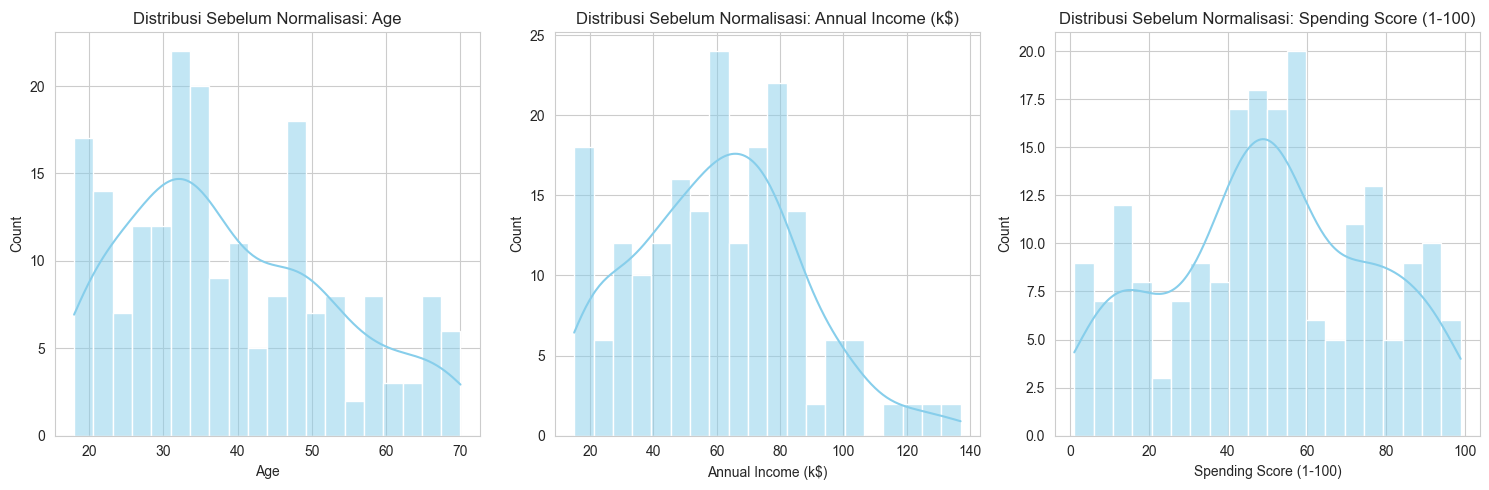

In [40]:
# Analisis distribusi sebelum normalisasi
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
data_num = df[numeric_cols]

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data_num[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribusi Sebelum Normalisasi: {col}')
plt.tight_layout()
plt.show()

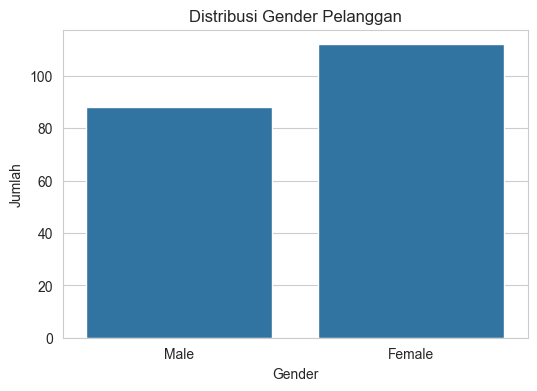

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender')
plt.title('Distribusi Gender Pelanggan')
plt.xlabel('Gender')
plt.ylabel('Jumlah')
plt.show()

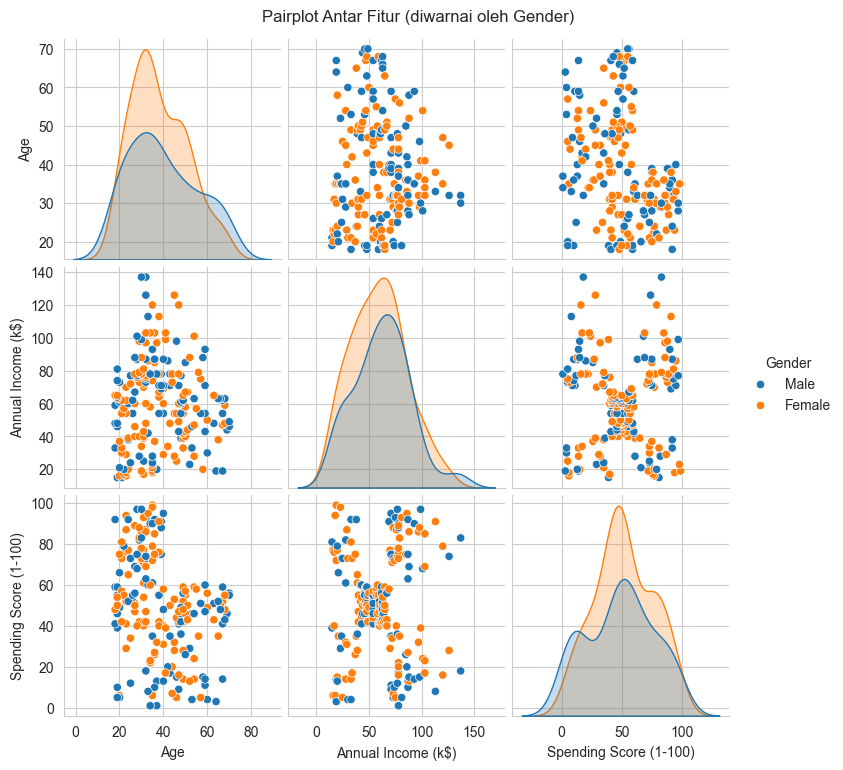

In [42]:
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', diag_kind='kde')
plt.suptitle('Pairplot Antar Fitur (diwarnai oleh Gender)', y=1.02)
plt.show()

In [43]:
df_processed = df.copy()

# 1. Encoding 'Gender': Ubah Male=0, Female=1
df_processed['Gender'] = df_processed['Gender'].map({'Male': 0, 'Female': 1})

# 2. Pilih fitur yang akan digunakan untuk scaling dan clustering
# Kita akan gunakan semua fitur relevan
features_for_clustering = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df_features = df_processed[features_for_clustering]

print("Data setelah encoding (5 baris pertama):")
df_features.head()

Data setelah encoding (5 baris pertama):


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [44]:
# Inisialisasi Scaler
scaler = StandardScaler()

# Terapkan fit_transform ke data fitur kita
df_scaled_array = scaler.fit_transform(df_features)

# Konversi kembali ke DataFrame agar mudah dibaca
df_scaled = pd.DataFrame(df_scaled_array, columns=features_for_clustering)

print("Data setelah scaling (5 baris pertama):")
df_scaled.head()

Data setelah scaling (5 baris pertama):


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,-1.128152,-1.424569,-1.738999,-0.434801
1,-1.128152,-1.281035,-1.738999,1.195704
2,0.886405,-1.352802,-1.700830,-1.715913
3,0.886405,-1.137502,-1.700830,1.040418
4,0.886405,-0.563369,-1.662660,-0.395980


In [45]:
# Inisialisasi PCA dengan 2 komponen
pca = PCA(n_components=2)

# Terapkan PCA pada data yang sudah di-scaling
df_pca_array = pca.fit_transform(df_scaled)

# Buat DataFrame dari hasil PCA
df_pca = pd.DataFrame(df_pca_array, columns=['PC1', 'PC2'])

# Cetak informasi explained variance
print(f"Total Explained Variance oleh 2 PC: {pca.explained_variance_ratio_.sum():.4f}")

# Tampilkan 5 baris pertama data PCA
print(df_pca.head())

Total Explained Variance oleh 2 PC: 0.5992
        PC1       PC2
0 -0.406383 -0.520714
1 -1.427673 -0.367310
2  0.050761 -1.894068
3 -1.694513 -1.631908
4 -0.313108 -1.810483


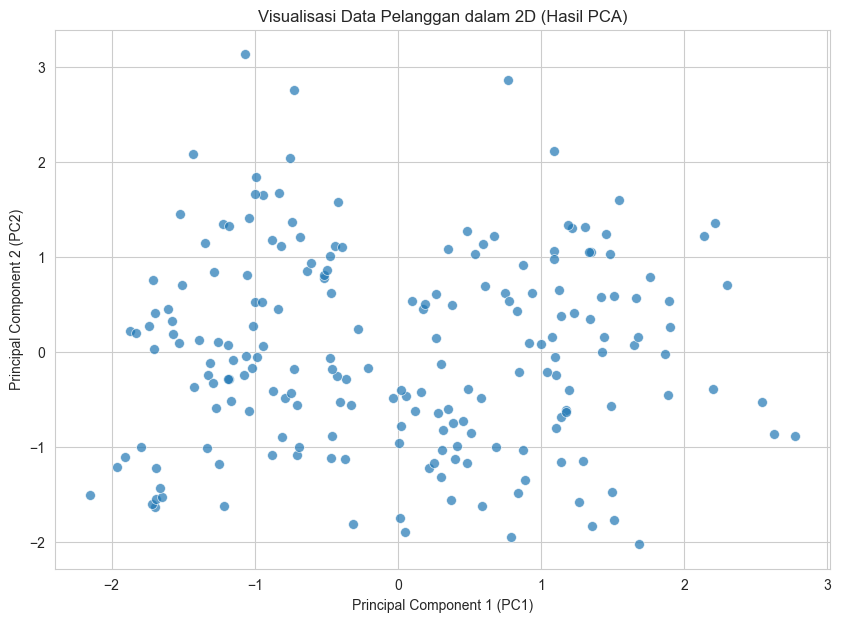

In [46]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', s=50, alpha=0.7)
plt.title('Visualisasi Data Pelanggan dalam 2D (Hasil PCA)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

**2. Clustering Implementation**

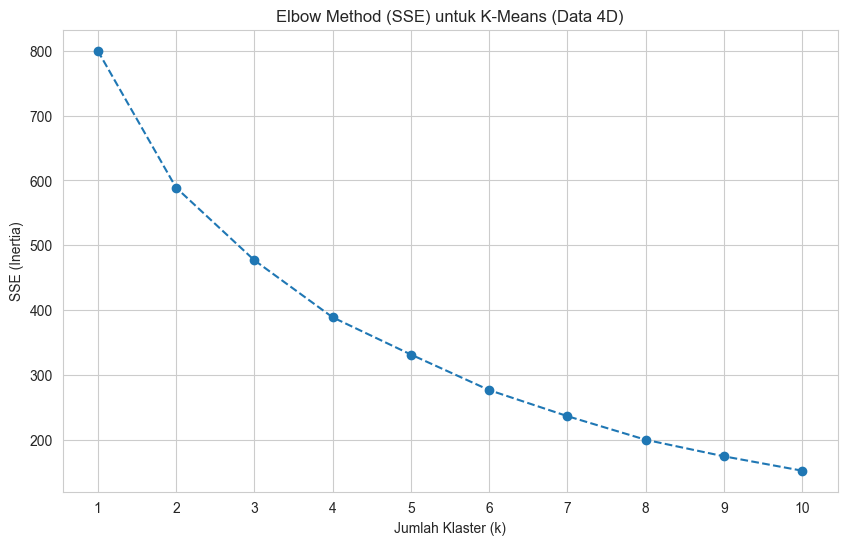

K-Means (k=5) selesai. Label ditambahkan.


In [47]:
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans_i = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_i.fit(df_scaled)
    sse.append(kmeans_i.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method (SSE) untuk K-Means (Data 4D)')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('SSE (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Berdasarkan plot, k=5 atau k=6 bisa menjadi pilihan. Mari kita coba k=5.
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Simpan label ke df_scaled (data latih) dan df_pca (data visualisasi)
df_scaled['Cluster_KMeans'] = kmeans_labels
df_pca['Cluster_KMeans'] = kmeans_labels
print(f"K-Means (k={optimal_k}) selesai. Label ditambahkan.")


--- 2.B: Implementasi Hierarchical Clustering (pada data 4D) ---


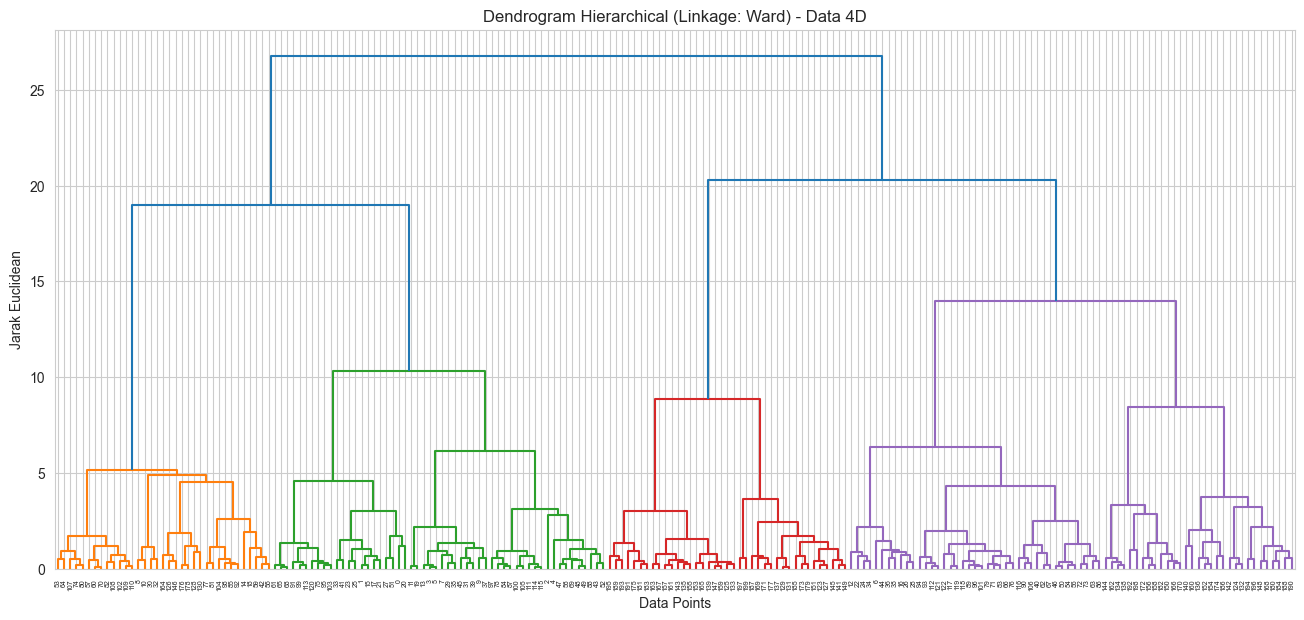

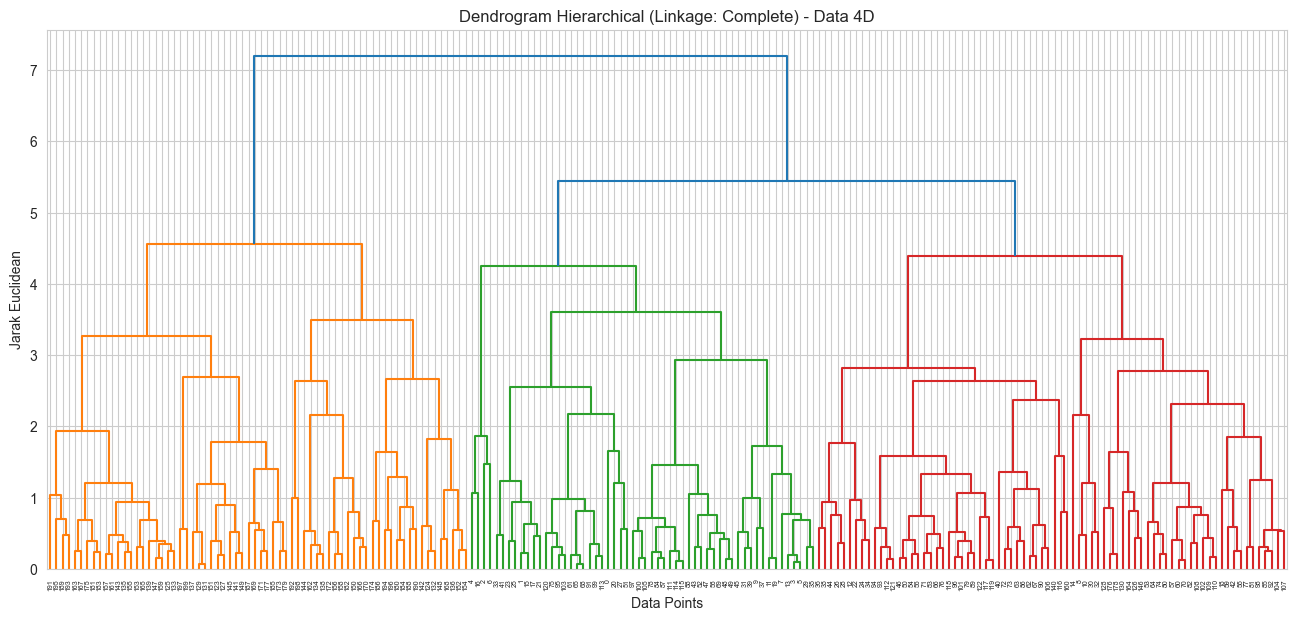

Hierarchical (Ward, k=5) selesai. Label ditambahkan.
Hierarchical (Complete, k=5) selesai. Label ditambahkan.


In [48]:
print("\n--- 2.B: Implementasi Hierarchical Clustering (pada data 4D) ---")
# Dendrogram 'ward'
plt.figure(figsize=(16, 7))
plt.title("Dendrogram Hierarchical (Linkage: Ward) - Data 4D")
dend_ward = sch.dendrogram(sch.linkage(df_scaled, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Jarak Euclidean")
plt.show()

# Dendrogram 'complete'
plt.figure(figsize=(16, 7))
plt.title("Dendrogram Hierarchical (Linkage: Complete) - Data 4D")
dend_complete = sch.dendrogram(sch.linkage(df_scaled, method='complete'))
plt.xlabel("Data Points")
plt.ylabel("Jarak Euclidean")
plt.show()

# Menjalankan klastering dengan k=5 (konsisten dengan K-Means)
n_clusters_h = 5

hc_ward = AgglomerativeClustering(n_clusters=n_clusters_h, linkage='ward')
ward_labels = hc_ward.fit_predict(df_scaled)
df_scaled['Cluster_Ward'] = ward_labels
df_pca['Cluster_Ward'] = ward_labels
print(f"Hierarchical (Ward, k={n_clusters_h}) selesai. Label ditambahkan.")

hc_complete = AgglomerativeClustering(n_clusters=n_clusters_h, linkage='complete')
complete_labels = hc_complete.fit_predict(df_scaled)
df_scaled['Cluster_Complete'] = complete_labels
df_pca['Cluster_Complete'] = complete_labels
print(f"Hierarchical (Complete, k={n_clusters_h}) selesai. Label ditambahkan.")


--- 2.C: Implementasi DBSCAN (pada data 4D) ---


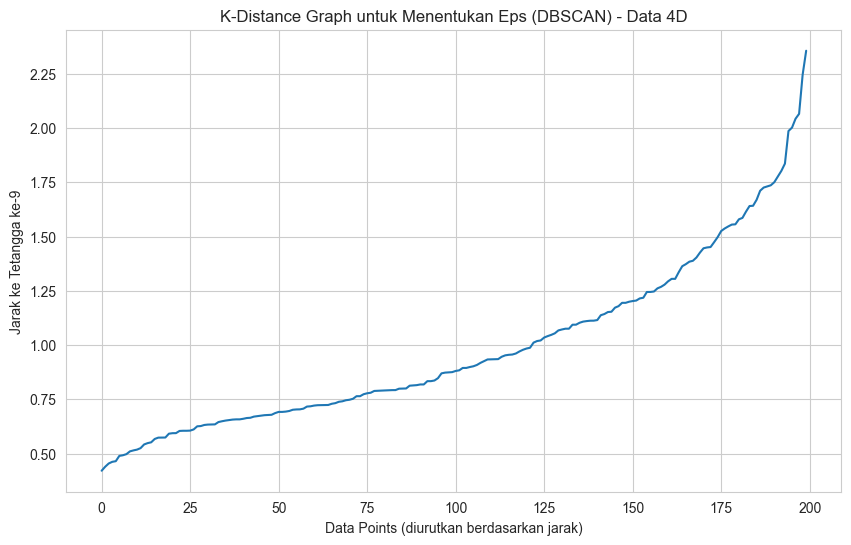

DBSCAN selesai (eps=1.3, min=9).
Hasil: Menemukan 8 klaster dan 9 noise points.

--- Visualisasi Perbandingan Hasil Klastering (pada plot PCA 2D) ---


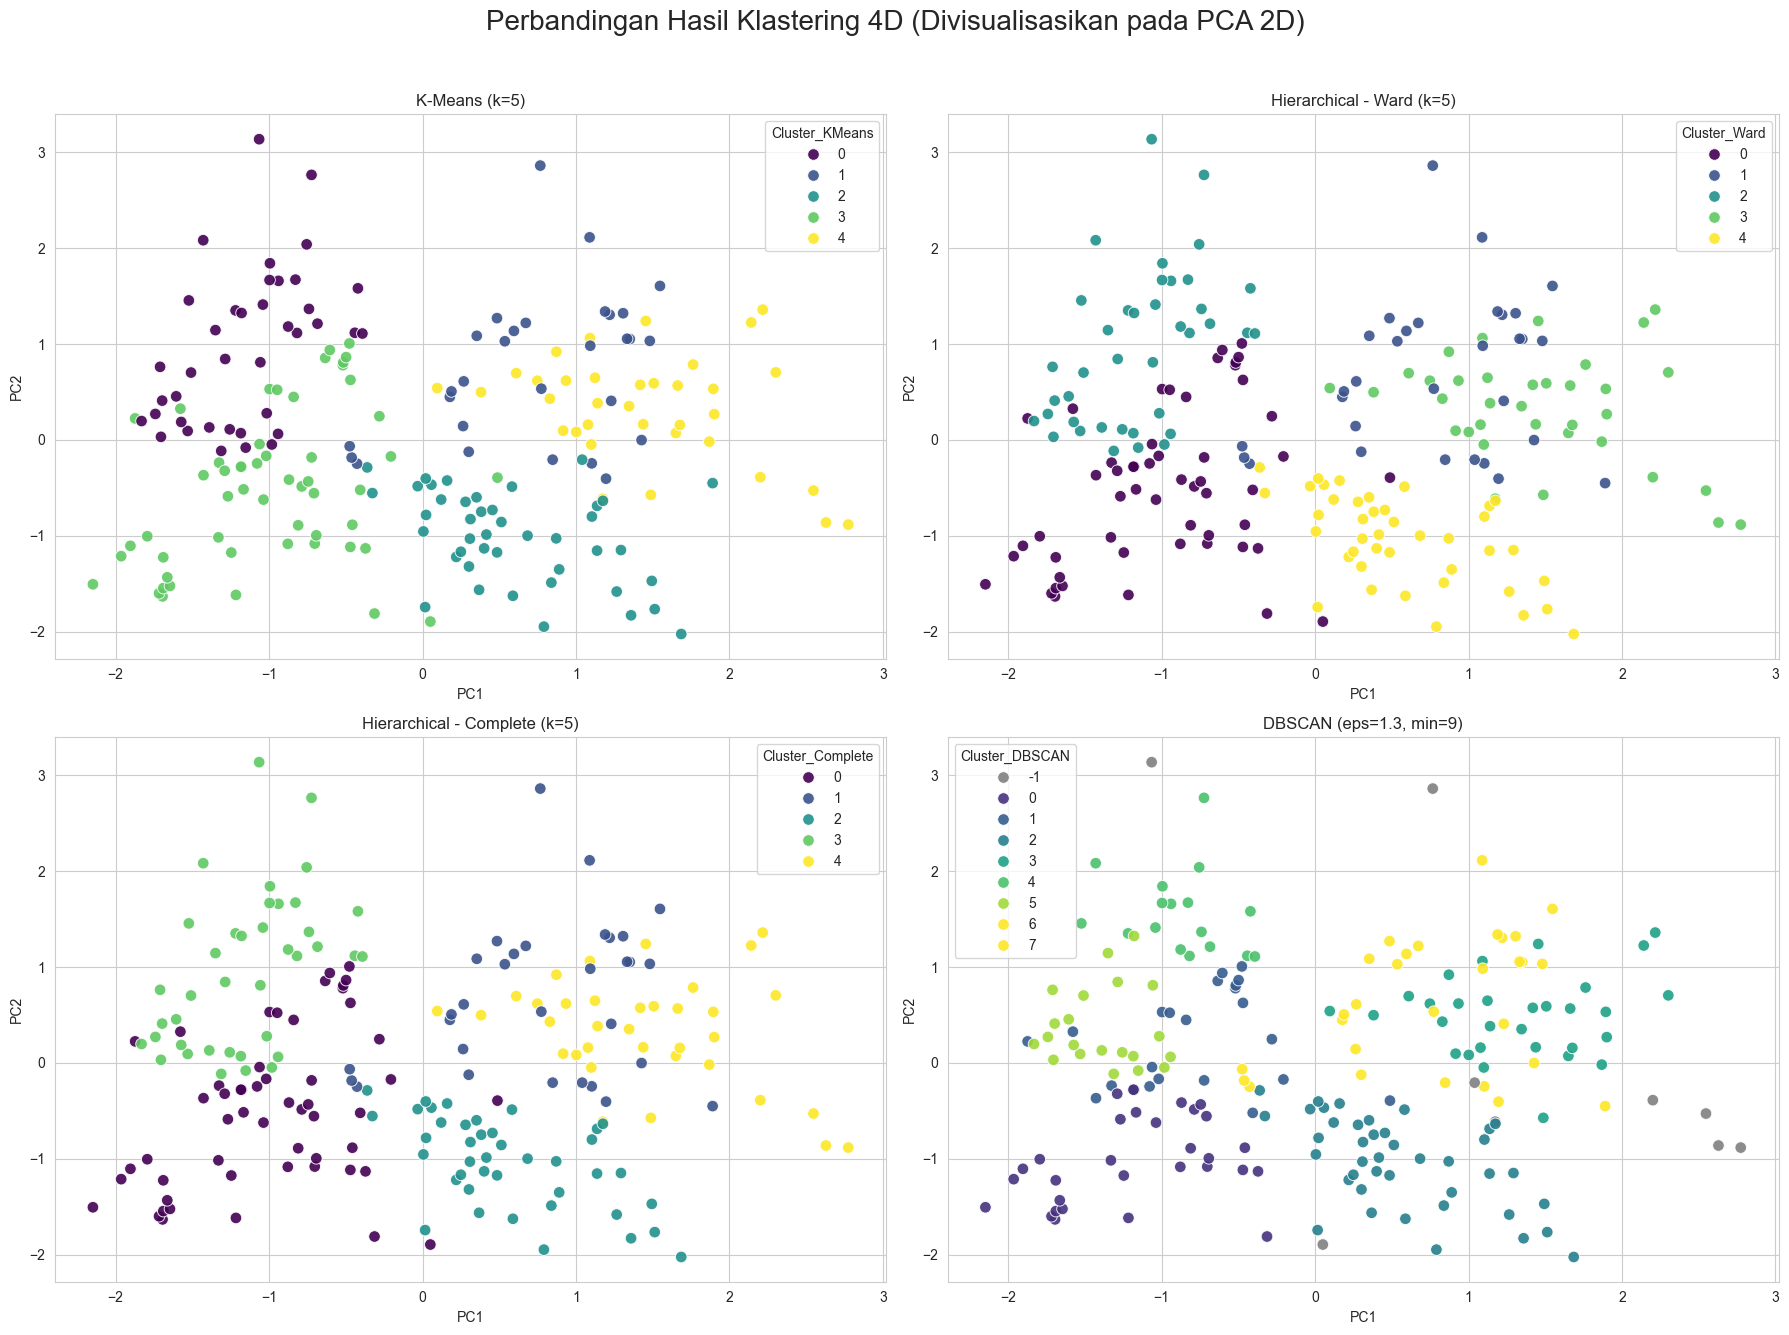

In [49]:
print("\n--- 2.C: Implementasi DBSCAN (pada data 4D) ---")
# Menentukan 'eps'
# Karena kita punya 4 fitur, min_samples = 2 * n_dim = 2 * 4 = 8. Kita gunakan 9 (8+1).
min_samples_dbscan = 9 
nn = NearestNeighbors(n_neighbors=min_samples_dbscan)
nn.fit(df_scaled)
distances, indices = nn.kneighbors(df_scaled)
k_distances = np.sort(distances[:, min_samples_dbscan-1], axis=0)

# Plot k-distance
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('K-Distance Graph untuk Menentukan Eps (DBSCAN) - Data 4D')
plt.xlabel('Data Points (diurutkan berdasarkan jarak)')
plt.ylabel(f'Jarak ke Tetangga ke-{min_samples_dbscan}')
plt.grid(True)
plt.show()

# Dari plot, "siku" (elbow) terlihat di sekitar y = 1.2 - 1.5. Mari kita pilih eps = 1.3
eps_dbscan = 1.3
dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
dbscan_labels = dbscan.fit_predict(df_scaled)

df_scaled['Cluster_DBSCAN'] = dbscan_labels
df_pca['Cluster_DBSCAN'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN selesai (eps={eps_dbscan}, min={min_samples_dbscan}).")
print(f"Hasil: Menemukan {n_clusters_dbscan} klaster dan {n_noise} noise points.")


# --- Visualisasi Perbandingan Hasil Klastering (Menggunakan PCA 2D) ---
print("\n--- Visualisasi Perbandingan Hasil Klastering (pada plot PCA 2D) ---")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Perbandingan Hasil Klastering 4D (Divisualisasikan pada PCA 2D)', fontsize=20)

# Sumbu X dan Y adalah Principal Components
x_axis = 'PC1'
y_axis = 'PC2'

# Plot 1: K-Means
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_KMeans', palette='viridis', s=70, alpha=0.9, ax=axes[0, 0], legend='full')
axes[0, 0].set_title(f'K-Means (k={optimal_k})')

# Plot 2: Hierarchical (Ward)
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_Ward', palette='viridis', s=70, alpha=0.9, ax=axes[0, 1], legend='full')
axes[0, 1].set_title(f'Hierarchical - Ward (k={n_clusters_h})')

# Plot 3: Hierarchical (Complete)
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_Complete', palette='viridis', s=70, alpha=0.9, ax=axes[1, 0], legend='full')
axes[1, 0].set_title(f'Hierarchical - Complete (k={n_clusters_h})')

# Plot 4: DBSCAN
# Buat palet custom untuk DBSCAN agar noise (-1) terlihat jelas
unique_labels = np.unique(df_pca['Cluster_DBSCAN'])
n_colors = len(unique_labels) - (1 if -1 in unique_labels else 0)
# Cek agar n_colors tidak 0 jika hanya ada noise
if n_colors > 0:
    colors = plt.cm.get_cmap('viridis', n_colors)
    palette_dbscan = {label: colors(i) for i, label in enumerate(unique_labels) if label != -1}
else:
    palette_dbscan = {} # Hanya noise
palette_dbscan[-1] = (0.5, 0.5, 0.5, 0.5) # Abu-abu transparan untuk noise

sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_DBSCAN', palette=palette_dbscan, s=70, alpha=0.9, ax=axes[1, 1], legend='full')
axes[1, 1].set_title(f'DBSCAN (eps={eps_dbscan}, min={min_samples_dbscan})')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()



**3. Evaluasi dan Validasi Klaster**


HASIL EVALUASI DAN VALIDASI KLASTER (LANGKAH 3)

--- 1. SSE (Sum of Squared Errors) ---
SSE (Inertia) untuk K-Means (k=5): 331.3099
(Nilai SSE ini diambil dari variabel 'sse' yang dibuat di Langkah 2)

--- 2. Tabel Metrik (Silhouette, Dunn, Purity) ---
                         Silhouette (Makin tinggi makin baik)  \
K-Means                                              0.574183   
Hierarchical (Ward)                                  0.579580   
Hierarchical (Complete)                              0.579580   
DBSCAN (non-noise)                                   0.597516   

                         Dunn Index (Makin tinggi makin baik)  \
K-Means                                              0.143996   
Hierarchical (Ward)                                  0.322895   
Hierarchical (Complete)                              0.322895   
DBSCAN (non-noise)                                   0.659013   

                         Purity (vs Gender) (Makin tinggi makin baik)  
K-Means               

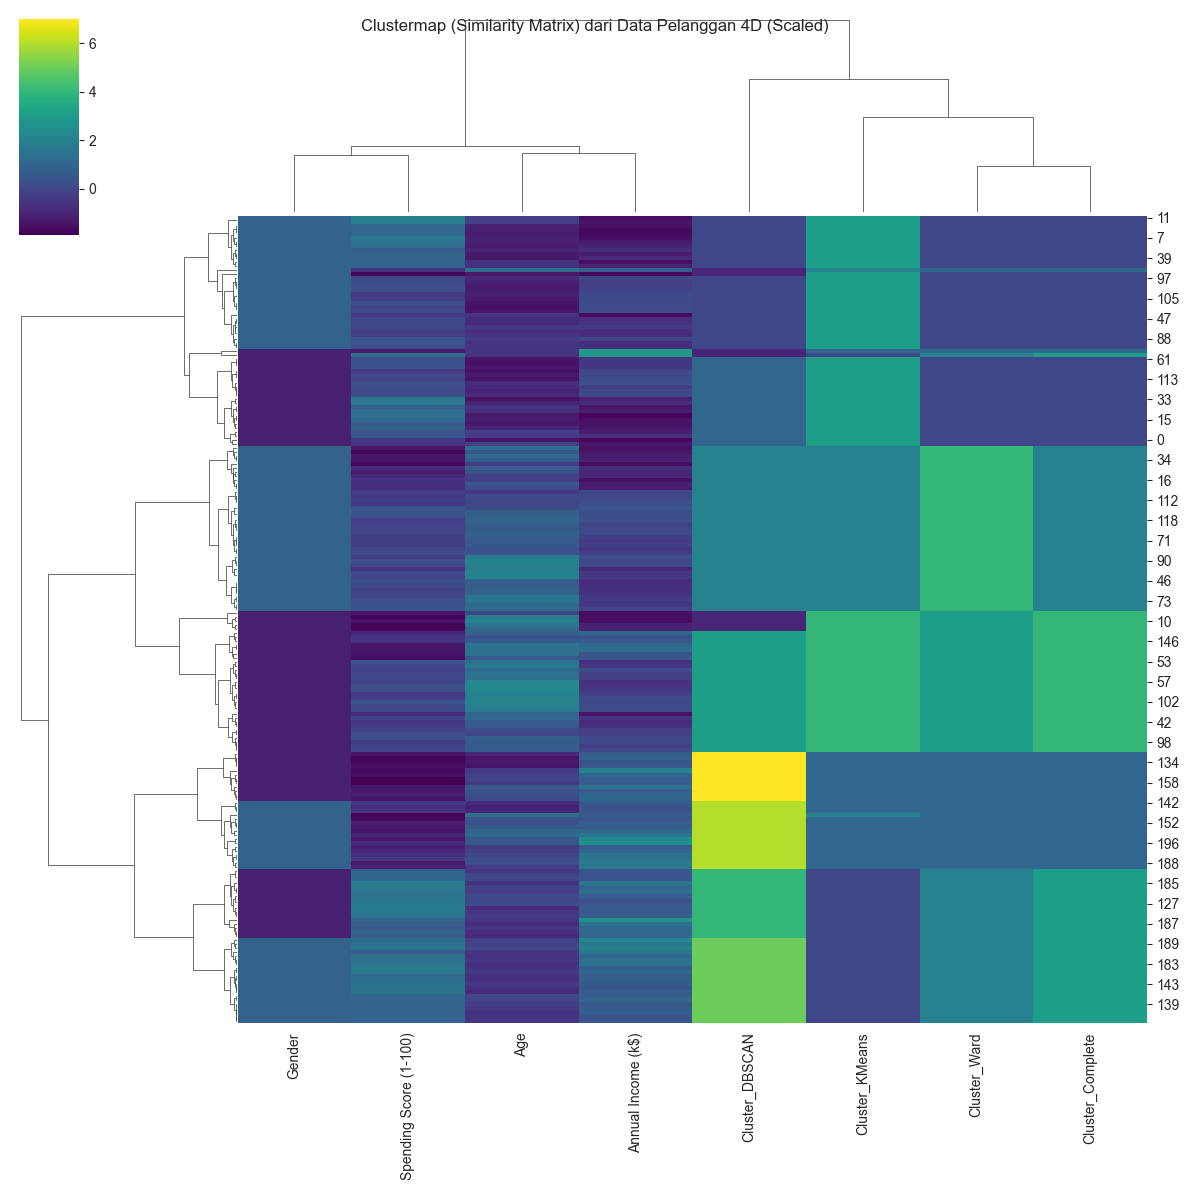

In [ ]:
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) <= 1:
        return 0.0 
    
    max_diameter = 0.0
    for k in unique_clusters:
        cluster_points = X[labels == k]
        if len(cluster_points) > 1:
            diameter = np.max(pdist(cluster_points, 'euclidean'))
            if diameter > max_diameter:
                max_diameter = diameter
    
    if max_diameter == 0:
        return 0.0
        
    min_inter_dist = np.inf
    for k1 in unique_clusters:
        for k2 in unique_clusters:
            if k1 >= k2:
                continue
            
            cluster1_points = X[labels == k1]
            cluster2_points = X[labels == k2]
            
            for p1 in cluster1_points:
                for p2 in cluster2_points:
                    dist = np.linalg.norm(p1 - p2)
                    if dist < min_inter_dist:
                        min_inter_dist = dist
                        
    return min_inter_dist / max_diameter

def calculate_purity(y_true_proxy, y_pred):
    mat = contingency_matrix(y_true_proxy, y_pred)
    return np.sum(np.max(mat, axis=0)) / np.sum(mat)

data_eval = df_scaled.values

ground_truth_purity = df['Gender'].values 

metrics_results = {}

labels_dict = {
    "K-Means": kmeans_labels,
    "Hierarchical (Ward)": ward_labels,
    "Hierarchical (Complete)": complete_labels
}

for name, labels in labels_dict.items():
    sil = silhouette_score(data_eval, labels)
    
    dunn = dunn_index(data_eval, labels)
    
    purity = calculate_purity(ground_truth_purity, labels)

    metrics_results[name] = [sil, dunn, purity]

non_noise_mask = dbscan_labels != -1
if np.sum(non_noise_mask) > 1 and len(set(dbscan_labels[non_noise_mask])) > 1:
    data_dbscan = data_eval[non_noise_mask]
    labels_dbscan = dbscan_labels[non_noise_mask]
    gt_dbscan = ground_truth_purity[non_noise_mask]
    
    sil_db = silhouette_score(data_dbscan, labels_dbscan)
    dunn_db = dunn_index(data_dbscan, labels_dbscan)
    purity_db = calculate_purity(gt_dbscan, labels_dbscan)
    
    metrics_results["DBSCAN (non-noise)"] = [sil_db, dunn_db, purity_db]
else:
    metrics_results["DBSCAN (non-noise)"] = [np.nan, np.nan, np.nan]

print("\n" + "="*50)
print("HASIL EVALUASI DAN VALIDASI KLASTER (LANGKAH 3)")
print("="*50)

print("\n--- 1. SSE (Sum of Squared Errors) ---")
try:
    print(f"SSE (Inertia) untuk K-Means (k={optimal_k}): {sse[optimal_k-1]:.4f}")
except NameError:
    print("Variabel 'sse' tidak ditemukan. Pastikan Langkah 2.A telah dijalankan.")
except IndexError:
    print(f"Error: 'optimal_k' (={optimal_k}) di luar jangkauan list 'sse'.")
    
print("(Nilai SSE ini diambil dari variabel 'sse' yang dibuat di Langkah 2)")

# --- 2. Menampilkan Silhouette, Dunn, dan Purity ---
print("\n--- 2. Tabel Metrik (Silhouette, Dunn, Purity) ---")
df_metrics = pd.DataFrame.from_dict(metrics_results, orient='index', 
                                   columns=['Silhouette (Makin tinggi makin baik)', 
                                            'Dunn Index (Makin tinggi makin baik)', 
                                            'Purity (vs Gender) (Makin tinggi makin baik)'])
print(df_metrics)

print("\n--- 3. Catatan tentang Entropy & Purity ---")
print("Purity dan Entropy adalah metrik eksternal (memerlukan Ground Truth).")
print("Purity di atas dihitung menggunakan 'Gender' sebagai *proxy* ground truth.")
print("   - Purity tinggi (mendekati 1) berarti klaster 'murni'.")
print("   - Entropy adalah kebalikan dari Purity. Purity tinggi = Entropy rendah.")

print("\n--- 4. Similarity Matrix (Clustermap) ---")
print("Membuat Clustermap...")

g = sns.clustermap(
    df_scaled,  # Gunakan data 4D yang di-scale
    cmap='viridis',
    metric='euclidean',
    method='ward', # 'ward' adalah metode linkage
    figsize=(12, 12)
)
g.fig.suptitle('Clustermap (Similarity Matrix) dari Data Pelanggan 4D (Scaled)')
plt.show()

**4. Analisis Hasil**

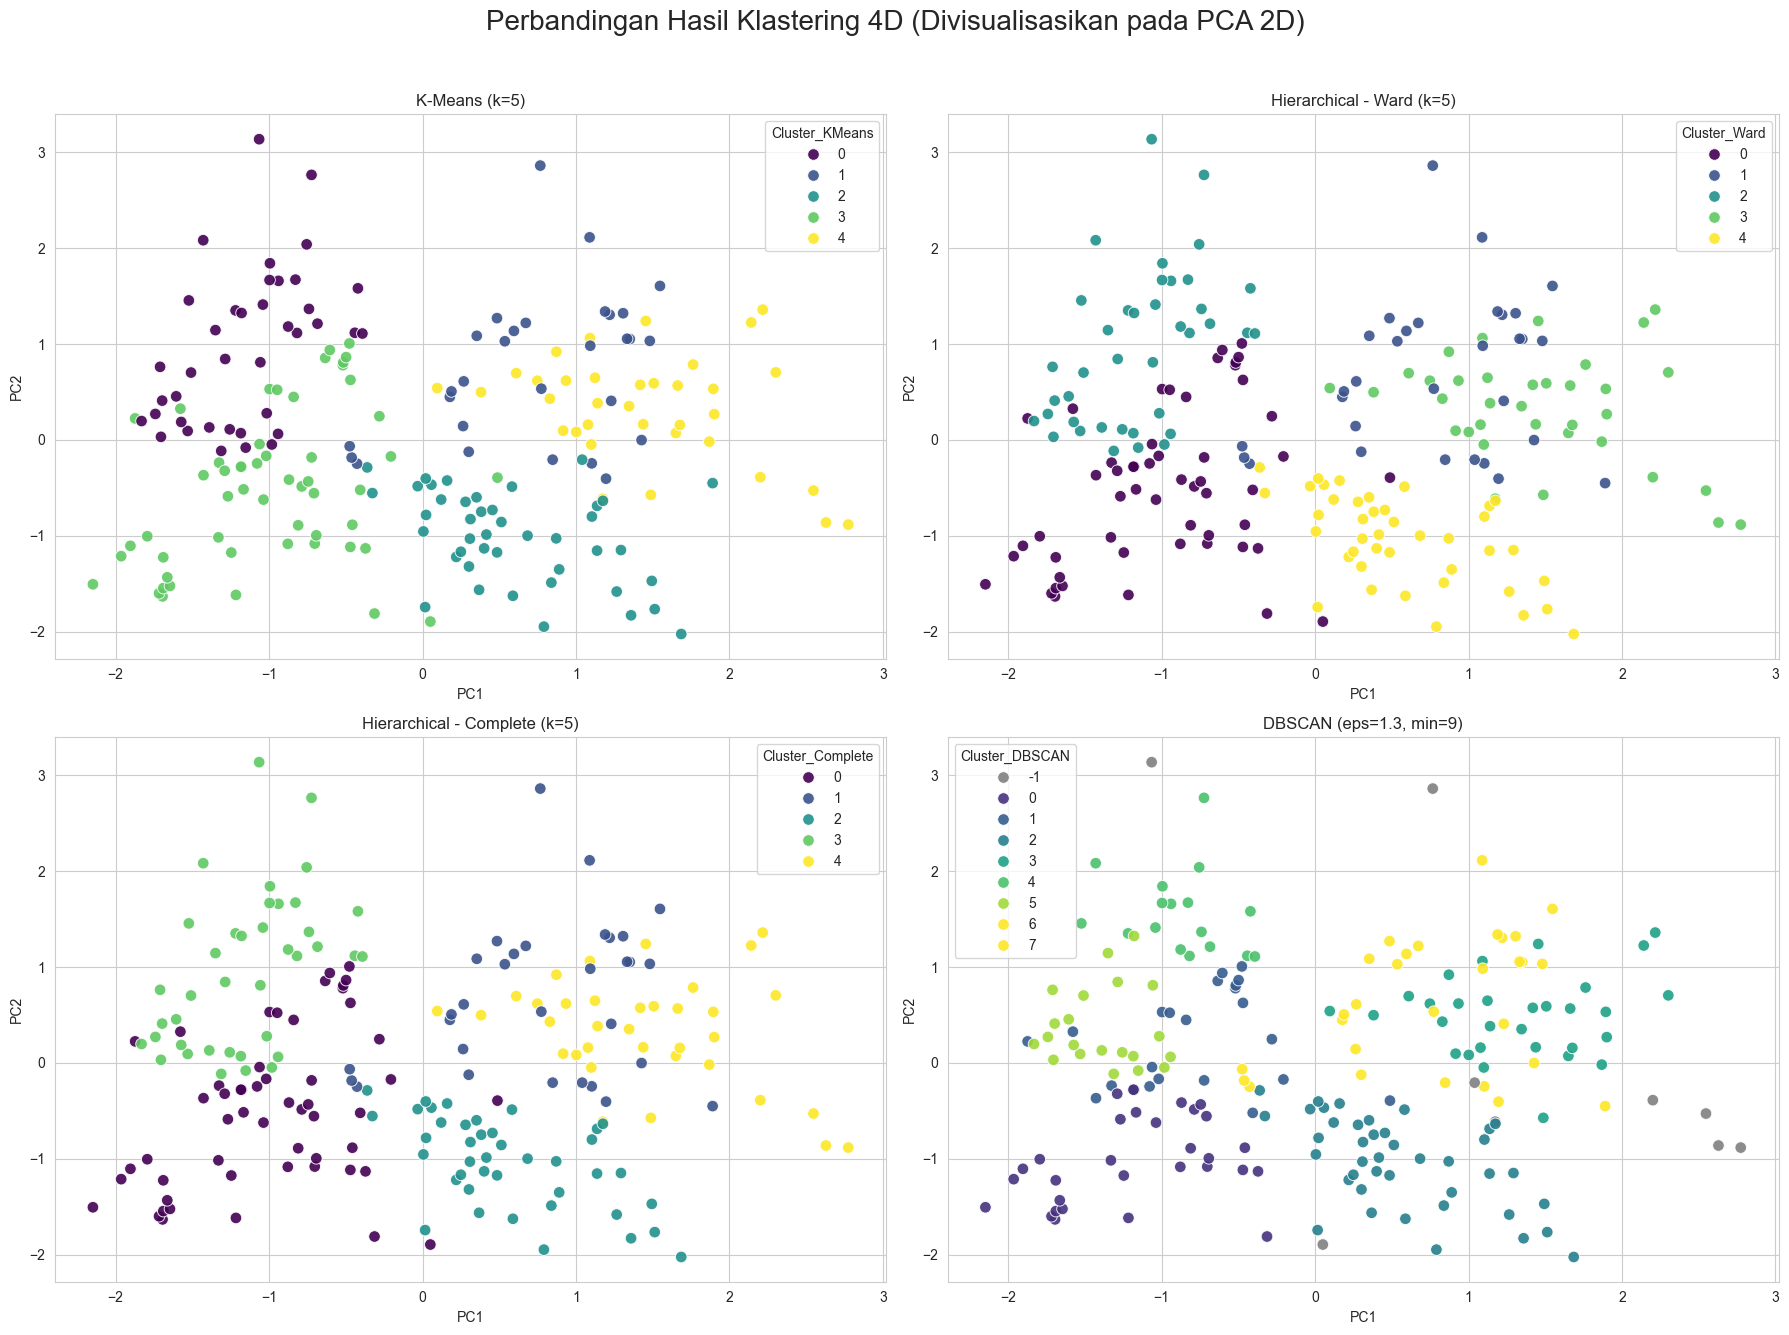

In [55]:
# (Pastikan 'df_pca' dan semua label klaster sudah ada dari Langkah 2)

# Membuat subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Perbandingan Hasil Klastering 4D (Divisualisasikan pada PCA 2D)', fontsize=20)

# Sumbu X dan Y adalah Principal Components
x_axis = 'PC1'
y_axis = 'PC2'

# --- Plot 1: K-Means ---
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_KMeans', palette='viridis', s=70, alpha=0.9, ax=axes[0, 0], legend='full')
axes[0, 0].set_title(f'K-Means (k={optimal_k})')

# --- Plot 2: Hierarchical (Ward) ---
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_Ward', palette='viridis', s=70, alpha=0.9, ax=axes[0, 1], legend='full')
axes[0, 1].set_title(f'Hierarchical - Ward (k={n_clusters_h})')

# --- Plot 3: Hierarchical (Complete) ---
sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_Complete', palette='viridis', s=70, alpha=0.9, ax=axes[1, 0], legend='full')
axes[1, 0].set_title(f'Hierarchical - Complete (k={n_clusters_h})')

# --- Plot 4: DBSCAN ---
# Palet custom untuk DBSCAN (agar noise -1 terlihat abu-abu)
unique_labels = np.unique(df_pca['Cluster_DBSCAN'])
n_colors = len(unique_labels) - (1 if -1 in unique_labels else 0)
if n_colors > 0:
    colors = plt.cm.get_cmap('viridis', n_colors)
    palette_dbscan = {label: colors(i) for i, label in enumerate(unique_labels) if label != -1}
else:
    palette_dbscan = {}
palette_dbscan[-1] = (0.5, 0.5, 0.5, 0.5) # Abu-abu untuk noise

sns.scatterplot(data=df_pca, x=x_axis, y=y_axis, hue='Cluster_DBSCAN', palette=palette_dbscan, s=70, alpha=0.9, ax=axes[1, 1], legend='full')
axes[1, 1].set_title(f'DBSCAN (eps={eps_dbscan}, min={min_samples_dbscan})')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()